In [1]:
cd ../

/wk171/ytkuo/TCRI_reanalysis


In [2]:
%env CUDA_VISIBLE_DEVICES=-1

env: CUDA_VISIBLE_DEVICES=-1


In [3]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)
from modules.data_handler import ascii_array_to_string
import pandas as pd
import numpy as np
from tqdm import tqdm

2023-04-14 12:44:38.003320: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
# fet experiment settings from yaml file
from modules.experiment_helper import parse_experiment_settings

experiment_path = 'experiments/cnn.yml'
experiment_settings = parse_experiment_settings(experiment_path)

In [5]:
# load dataset
from modules.data_handler import get_tensorflow_datasets

datasets = get_tensorflow_datasets(**experiment_settings['data'])

2023-04-14 12:44:39.303235: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-14 12:44:39.365376: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-14 12:44:39.365419: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ubuntu
2023-04-14 12:44:39.365432: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ubuntu
2023-04-14 12:44:39.365575: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.39.0
2023-04-14 12:44:39.365612: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.39.0
2023-04-14 12:44:39.365623: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.39.0
2023-04-14 12:44:39.366073: I tensorflow/core/platform/cpu_feature_gua

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [6]:
# load trained model
from modules.model_constructor import create_model_by_experiment_path

model = create_model_by_experiment_path(experiment_path, version='best-MSE')

saved_models/cnn/best-MSE


In [7]:
df = pd.DataFrame(columns=['now','24h_Vmax', 'pred_24h_Vmax', 'starting_frame'])
for image_sequences, labels, feature,frame_ID_ascii, dV in tqdm(datasets['test']):
    starting_frame = list(map(ascii_array_to_string, frame_ID_ascii.numpy()))
    pred = np.squeeze(model(image_sequences, feature).numpy())
    V24 = labels.numpy()
    now = V24 - dV.numpy()
    batch_size = pred.shape[0]
    for i in range(batch_size):
        df.loc[df.shape[0]] = [now[i], V24[i], pred[i], starting_frame[i]]

0it [00:00, ?it/s]2023-04-14 12:44:40.072222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-14 12:44:40.073032: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199915000 Hz
2023-04-14 12:44:40.085183: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1653] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
194it [00:28,  6.88it/s]


In [8]:
df = df.sort_values(['starting_frame']).reset_index(drop=True).round(2)

In [9]:
df.head(40)

,now,24h_Vmax,pred_24h_Vmax,starting_frame
0,13.12,28.24,35.05,201901E_2019062515
1,13.12,30.55,32.24,201901E_2019062518
2,16.12,33.51,44.12,201901E_2019062521
3,18.12,35.24,39.34,201901E_2019062600
4,18.30,37.86,54.15,201901E_2019062603
5,18.68,39.13,43.37,201901E_2019062606
6,22.16,38.69,50.02,201901E_2019062609
7,24.64,38.32,50.38,201901E_2019062612
8,28.24,40.79,63.66,201901E_2019062615
9,30.55,42.33,57.04,201901E_2019062618


In [10]:
(abs(df.pred_24h_Vmax- df['24h_Vmax'])).mean()

10.704191783649877

In [12]:
(abs(df.pred_24h_Vmax- df.now)).mean()

14.418202931461604

In [11]:
df.to_csv('./saved_csv/large_dropout.csv', index = False)

In [7]:
import matplotlib.pyplot as plt

In [8]:
for image_sequences, labels, feature,frame_ID_ascii, dV in datasets['test']:
    break

2023-04-13 16:46:25.769778: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-13 16:46:25.788672: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199915000 Hz
2023-04-13 16:46:25.799923: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1653] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


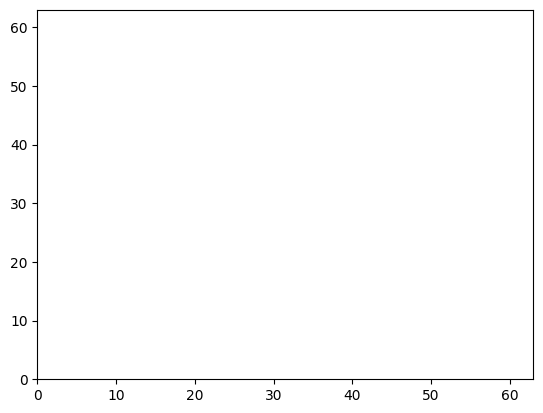

In [9]:
tmp = image_sequences[:,0,:,:,0]
tmp = np.nanmean(tmp, axis = 0)
plt.contourf(tmp, levels=np.linspace(200,280))